This notebook is for modeling who will be more likely to respond to the mail campaign (so that we can send the campaigns to them rather than to all the candidates). 

Key parts in the notebook:

**Customized train_test_split**

In the training data, only 1.2% of the people responded. We have to deal with the problem of data imbalance. We wrote a customized function to do the job of `train_test_split`. We will sample 20% from the customers who responded to the campaign and 20% from the customers who didn't respond seperately to the final test set to make sure that in training set, 1.2% of the people responded and in testing set, that ratio is also 1.2%.

**Resampler during the modeling**

Since we have serious data imbalance problem, we will upsample the people who responded and downsample the people who didn't respond when training the model.

**Modeling**

To shorten the notebook, we didn't show all the efforts we did when trying to find the "best model". We tried several models --- Random Forest, Gradient Boosting and the Xgboost algorithm. We found that `XGBClassifier` worked the best here... We also tried a bunch of parameters combinations. But again, to shorten the notebook, we only displayed a small part of the efforts. 

**Prediction**

We will make prediction on the test data and submit the result to this competition https://www.kaggle.com/c/udacity-arvato-identify-customers/overview.
**My current AUC score is more than 0.8!**

**Feature importance**

In the end we will take a look at the important features that contributed the most to our model.


# Load data and packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/attributes/attribute_values_cleaned_checkpoint.csv
/kaggle/input/customer-train-transformed-new/train_transformed.csv
/kaggle/input/test-data/test.csv


In [2]:
import itertools
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('max_rows', 400)

In [3]:
train_transformed = pd.read_csv("../input/customer-train-transformed-new/train_transformed.csv")

In [4]:
X = train_transformed.drop('y', axis=1).values
y = train_transformed['y']

In [31]:
len(train_transformed)

42962

# Prepare helper functions for the modeling pipeine

In [5]:
def customize_train_test_split(data,
                               tag_col,
                               minority_tag_value):
    
    """
    Do train_test_split on minority group and majority group seperately
    -- sample 20% minority and 20% majority to the final test set
    
    This process doesn't drop any columns
    
    Input:
        data: the data to split
        tag_col: column for the class label
        minority_tag_value: class label that has very few representatives
    """
    
    data_minor = data[data[tag_col] == minority_tag_value]
    data_major = data[data[tag_col] != minority_tag_value]
    
    train_minor, test_minor = train_test_split(data_minor, test_size=0.2)
    train_major, test_major = train_test_split(data_major, test_size=0.2)
    
    train = pd.concat([train_minor, train_major]).sample(frac=1)
    test = pd.concat([test_minor, test_major]).sample(frac=1)
    
    return train, test

In [6]:
def resampler(data, 
              tag_col,
              minority_tag_value,
              minority_group_size,
              majority_group_size):
    
    """
    Handle the imbalanced data
    
    For minority group we upsample the data with replacement; 
    For majority group we downsample the data without replacement;
    
    This process doesn't drop any columns
    
    Input:
        data: the data to split
        tag_col: column for the class label
        minority_tag_value: class label that has very few representatives
        minority_group_size: group size of the minority group after resampling
        majority_group_size: group size of the majority group after resampling
    """
    
    minority_resample = resample(data[data[tag_col] == minority_tag_value], 
                                 replace=True,
                                 n_samples=minority_group_size)
    majority_resample = resample(data[data[tag_col] != minority_tag_value], 
                                 replace=False,
                                 n_samples=majority_group_size)
    resampled_data = pd.concat([minority_resample, majority_resample])
    return resampled_data

In [7]:
def train_model(X, y, learning_rate=0.1, max_depth=10, gamma=0.5, subsample=1):
    
    """
    A general function for a machine learning pipeline of 
    (1) scaling all the variables
    (2) training a GradientBoostingClassifier with specified parameters
    
    The model returned is a trained Pipeline object
    """
    
    clf = XGBClassifier(learning_rate=learning_rate, 
                         max_depth=max_depth, 
                         gamma=gamma,
                         subsample=subsample)
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    model.fit(X, y)

    return model

In [8]:
def resampler_stratify(data, 
              tag_col,
              stratify_col,
              minority_tag_value,
              minority_group_size,
              majority_group_size):
    
    """
    Handle the imbalanced data with stratify sampling
    
    For minority group we upsample the data with replacement; 
    For majority group we downsample the data without replacement;
    
    Due to the samll trick we use when sampling the data, the final group size won't be exactly the same as the ones we specified, but they will be very very close
    
    This process doesn't drop any columns
    
    Input:
        data: the data to split
        tag_col: column for the class label
        stratify_col: column for stratify sampling
        minority_tag_value: class label that has very few representatives
        minority_group_size: group size of the minority group after resampling
        majority_group_size: group size of the majority group after resampling
    """
    
    minority_resample = resample(data[data[tag_col] == minority_tag_value], 
                                 replace=True,
                                 n_samples=minority_group_size)
    
    majority_data = data[data[tag_col] != minority_tag_value]
    majority_resample, _ = train_test_split(majority_data, 
                                     test_size=1-majority_group_size/len(data),
                                     stratify=majority_data[stratify_col])
    resampled_data = pd.concat([minority_resample, majority_resample])
    return resampled_data.drop(stratify_col, axis=1)

In [9]:
def test_model(model, X, y, thred_proba=0.5):
    
    """
    A general function for checking the f1, precision and recall score of the model and plotting the ROC curve;
    thred_proba: probability threshold to determine if an outcome is positive or negative. For example, we predict a person to have a 45% chance
    to respond to the ad; If the thred_proba is 50%, then we don't think that the person will respond to the ad; If the thred_proba is 40%, we 
    will consider that the person will respond to the ad
    
    Output is a dictionary with 'precision', 'recall' and 'f1'
    """
    y_pred_proba = model.predict_proba(test.drop(['y','kmeans_label'], axis=1))[:,1]
    y_pred = np.array([int(i) for i in (y_pred_proba > thred_proba)])
    result = {}
    result['precision'] = precision_score(y, y_pred)
    result['recall'] = recall_score(y, y_pred)
    result['f1'] = f1_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return result

In [10]:
def test_model_proba(model, X, y):
    
    """
    A general function for plotting the ROC curve;
    Unlike the function `test_model`, we will use `predict_proba` to calculate `y_pred`
    
    This function doesn't have putput
    """
    
    y_pred = model.predict_proba(test.drop(['y','kmeans_label'], axis=1))[:,1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def train_model_full(train, 
                     y_col_name,
                     minority_group_size, 
                     majority_group_size, 
                     stratify_sample=False,
                     stratify_col_name=None,
                     learning_rate=0.1, 
                     max_depth=6, 
                     gamma=0.5,
                     subsample=1):
    
    """
    A general function of of resampling the data and training a model.
    
    Input:
        train: the training data (after train_test_split)
        y_col_name: column name for the label column
        minority_group_size: group size of the minority group after resampling
        majority_group_size: group size of the majority group after resampling
        stratify_sample: whether we will do stratify sampling when upsample/downsample the data
        stratify_col_name: column for stratify sampling
        learning_rate: parameter for XGBClassifier 
        max_depth: parameter for XGBClassifier 
        gamma: parameter for XGBClassifier 
        subsample: parameter for XGBClassifier 
    """
    if not stratify_sample:
        re_train = resampler(train, y_col_name, 1, minority_group_size, majority_group_size)
    else:
        re_train = resampler_stratify(train, y_col_name, stratify_col_name, 1, minority_group_size, majority_group_size)
    X = re_train.drop(y_col_name, axis=1)
    y = re_train[y_col_name]
    model = train_model(X, 
                        y, 
                        learning_rate=learning_rate, 
                        max_depth=max_depth, 
                        gamma=gamma)
    
    return model

In [12]:
def evaluate(model, X_test, y_test):
    """
    Returns the test-auc of the model;
    When calculating auc, we will use the predicted probabilities (for the positive class)
    """
    y_pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

# Tune the model

## Prepare the training data

In [13]:
trans_X_y = pd.DataFrame(X, columns=list(train_transformed.columns[:-2])+['kmeans_label'])
trans_X_y['y'] = y

train, test = customize_train_test_split(trans_X_y, 'y', 1)

In [14]:
train.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,...,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,HEALTH_TYP_1.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,kmeans_label,y
32939,-0.981753,0.701825,-0.492754,-0.132882,-0.320053,0.246001,-0.486587,-0.063097,-1.774118e-01,-1.526398,0.196994,0.196994,0.643159,1.117603,-1.735371,-0.855072,1.183823,1.215081,1.192030,1.157898,-0.228259,-0.294032,0.42206,-0.443741,-0.345901,-0.132111,0.120874,0.362409,-0.327518,-0.281739,-0.303388,2.141372,-0.296161,-0.205967,1.732624,5.597485,-0.384133,-0.259375,-0.343098,-0.211033,-0.599439,-0.717752,0.288932,-0.584918,0.434104,-0.906208,-0.397223,-0.474667,-0.419129,-1.193278,...,-0.556886,-0.389460,-0.456895,-0.390483,-0.242047,3.963766,-0.310271,-0.167854,-0.26032,-0.631867,-0.252964,-0.23516,-0.258954,-0.277611,-0.394698,-0.177219,4.443793,-0.331084,-0.270140,-0.373540,-0.313472,-0.429034,2.118542,-0.724803,-0.731567,-0.33457,-0.431114,-0.464455,-0.386105,-0.255074,-0.24295,-0.183987,-0.160792,-0.187677,-0.241043,-0.219855,-0.195532,3.316440,-0.408743,-0.632675,-0.550832,1.919697,-0.401311,-0.196615,1.200973,-0.555385,-0.324607,-0.301964,4.0,0
20752,-0.981753,1.385084,-0.492754,-0.132882,1.757969,1.149211,-0.486587,-0.063097,-1.774118e-01,-0.558192,-1.507347,-1.507347,-1.625217,0.446263,-1.002555,-0.855072,0.465793,0.484798,0.464879,1.157898,-0.228259,-0.294032,0.42206,-0.443741,-0.345901,-0.132111,0.120874,0.362409,-0.327518,-0.281739,4.235730,2.582484,-0.296161,5.383626,1.732624,-0.189770,3.609576,-0.259375,3.142030,-0.211033,-0.599439,1.018493,-0.022331,-0.584918,0.763066,-0.906208,2.905128,2.789727,-0.419129,-0.573269,...,-0.556886,-0.389460,-0.456895,2.560929,-0.242047,-0.252285,-0.310271,-0.167854,-0.26032,-0.631867,-0.252964,-0.23516,-0.258954,-0.277611,-0.394698,-0.177219,-0.225033,-0.331084,3.701786,-0.373540,-0.313472,-0.429034,2.118542,-0.724803,-0.731567,-0.33457,-0.431114,-0.464455,-0.386105,-0.255074,-0.24295,-0.183987,-0.160792,5.328313,-0.241043,-0.219855,-0.195532,-0.301528,-0.408743,1.580589,-0.550832,-0.520916,2.491835,-0.196615,-0.832658,-0.555385,-0.324607,-0.301964,5.0,0
2537,-0.981753,-0.391387,-0.492754,-0.132882,-0.320053,-0.657210,-0.486587,-0.063097,-1.234353e+00,1.378221,-0.229091,-0.229091,-0.037353,1.117603,-1.002555,-0.855072,1.183823,1.215081,1.192030,1.157898,-0.228259,-0.294032,0.42206,-0.443741,-0.345901,-0.132111,0.120874,0.362409,-0.327518,-0.281739,-0.303388,-0.505301,-0.296161,-0.20596

In [25]:
train['y'].value_counts()

0    33944
1      425
Name: y, dtype: int64

## First try with a set of parameters to get an idea of how our model will perform.

> Without stratify sampling

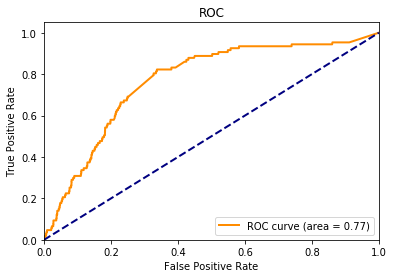

In [15]:
model1 = train_model_full(train.drop('kmeans_label', axis=1), 
                         'y',
                         1800, 
                         1500, 
                         stratify_sample=False,
                         learning_rate=0.01, 
                         max_depth=6, 
                         gamma=0.5,
                         subsample=1)

test_model_proba(model1, test.drop(['y','kmeans_label'], axis=1), test['y'])

> With stratify sampling

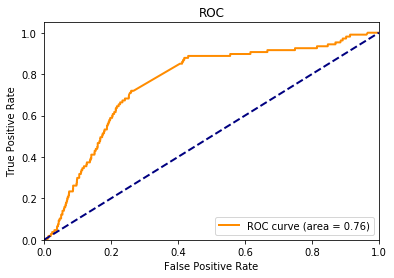

In [16]:
model2 = train_model_full(train, 
                         'y',
                         1800, 
                         1500, 
                         stratify_sample=True,
                         stratify_col_name='kmeans_label',
                         learning_rate=0.01, 
                         max_depth=6, 
                         gamma=0.8,
                         subsample=1)

test_model_proba(model2, test.drop(['y'], axis=1), test['y'])

## Start tuning!

Remember that we have many parameters and we have 2 sampling methods!

#### 2 sampling methods (sampling methods are very important because we will largely downsample the negative group and upsample the positive group):
* random sampling 
* stratify sampling (based on the kmeans clusters we fitted before)

#### Parameters:
* minority group size (sampling parameter)
* majority group size (sampling parameter)
* learning rate (xgboost classifier parameter)
* max depth (xgboost classifier parameter)
* gamma (xgboost classifier parameter)
* subsample (xgboost classifier parameter)

We will do 2 batches of tuning.

* Tune `minority group size` and `majority group size`

We will first fix the parameters for xgboost (given my experience, I kind of already know what parameters will work well for xgboost). We will only change `minority group size` and `majority group size` to figure out how we should best upsample the positive group and downsample the negative group. 

We will do the tuning twice -- with random sampling and with stratify sampling. We are not sure whether stratify sampling will help us a lot. 

* Tune xgboost parameters

Then we will fix the sampling parameters and only change the xgboost parameters. Unless stratify sampling does prove to help us a lot in the last round --- we will use random sampling. 

For each parameter combination, we run `train_model_full` 5 times and then calculate average loss. This is an approximate methods to 5 folds cross validation. Rather than spliting the data to 5 folds ahead and use one fold as validation set at one time, we randomly split data each time we run the model. I kind of trust this method because in our modeling pipine, only very small portion (no more than 10%) of the whole data will be entered to the training process. Even if we don't do very strict cross validation, there's very very little chance that the five sampled training sets are largely overlapped.

## First batch of parameters

We will first tune `minority_group_size` and `majority_group_size`

In [104]:
minority_group_size = [1200, 1500, 1800, 2000]
majority_group_size = [1200, 1500, 1800, 2000]
learning_rate = [0.01]
max_depth = [6]
gamma = [0.8]
subsample = [1]

params = list(itertools.product(*[minority_group_size,
                         majority_group_size,
                         learning_rate,
                         max_depth,
                         gamma,
                         subsample]))

In [105]:
#tune the parameters without stratify sampling

auc_list = []
begin = datetime.datetime.now()
for p in params: 
    print("params:",p)
    l = []
    for i in range(5):
        
        trans_X_y = pd.DataFrame(X, columns=list(train_transformed.columns[:-2])+['kmeans_label'])
        trans_X_y['y'] = y

        train, test = customize_train_test_split(trans_X_y, 'y', 1)
        
        model_temp = train_model_full(train.drop('kmeans_label', axis=1), 
                                     'y',
                                     p[0], 
                                     p[1], 
                                     stratify_sample=False,
                                     learning_rate=p[2], 
                                     max_depth=p[3], 
                                     gamma=p[4],
                                     subsample=p[5])
        l.append(evaluate(model_temp, test.drop(['y','kmeans_label'], axis=1), test['y']))
    print("auc:", l)
    print("average auc:", np.mean(l))
    print(" ")

    auc_list.append(l)
time_pass = (datetime.datetime.now() - begin).seconds / 60
print("running time: {:.2} min".format(time_pass))
average_auc_list = list(np.mean(np.array(auc_list), axis=1))
print("Maximum average auc: {}".format(max(average_auc_list)))
best_params = params[average_auc_list.index(max(average_auc_list))]
print("Best params : {}".format(best_params))

params: (1200, 1200, 0.01, 6, 0.8, 1)
auc: [0.770506562760875, 0.8029613370895659, 0.7608694694505078, 0.7716645998577095, 0.7587406195140538]
average auc: 0.7729485177345424
 
params: (1200, 1500, 0.01, 6, 0.8, 1)
auc: [0.7482455985779767, 0.7657785996066088, 0.7559801630392884, 0.7635632961160879, 0.7185215451067288]
average auc: 0.750417840489338
 
params: (1200, 1800, 0.01, 6, 0.8, 1)
auc: [0.7803143605410561, 0.7214092039444846, 0.7635423710520461, 0.7831106098885245, 0.7557703617392914]
average auc: 0.7608293814330807
 
params: (1200, 2000, 0.01, 6, 0.8, 1)
auc: [0.7213915828379233, 0.7761486208180159, 0.7697560137532735, 0.7589234384946288, 0.7587940334933183]
average auc: 0.757002737879432
 
params: (1500, 1200, 0.01, 6, 0.8, 1)
auc: [0.7450506716945557, 0.7636161594357722, 0.773187173596534, 0.7396007938308506, 0.7523347966193906]
average auc: 0.7547579190354207
 
params: (1500, 1500, 0.01, 6, 0.8, 1)
auc: [0.7291107288309937, 0.7391646714434549, 0.7301327530115572, 0.73246754

Browsing the training log, we found that the auc numbers didn't change much as we change the parameters. The best result came under the senario when we upsample the positive data points to 1200 and downsample the negative data points to 1200, which gave us an AUC of 0.7729.

In [20]:
#we will then tune with the stratify sampling. To save some time, I will shorten the candidate lists for minority_group_size and majority_group_size

minority_group_size = [1500, 1800, 2000]
majority_group_size = [1200, 1500, 1800]
learning_rate = [0.01]
max_depth = [6]
gamma = [0.8]
subsample = [1]

params = list(itertools.product(*[minority_group_size,
                         majority_group_size,
                         learning_rate,
                         max_depth,
                         gamma,
                         subsample]))

In [102]:
#tune the parameters with stratify sampling
#new!

auc_list = []
begin = datetime.datetime.now()
for p in params: 
    print("params:",p)
    l = []
    for i in range(5):
        
        trans_X_y = pd.DataFrame(X, columns=list(train_transformed.columns[:-2])+['kmeans_label'])
        trans_X_y['y'] = y

        train, test = customize_train_test_split(trans_X_y, 'y', 1)
        
        model_temp = train_model_full(train, 
                                     'y',
                                     p[0], 
                                     p[1], 
                                     stratify_sample=True,
                                     stratify_col_name='kmeans_label',
                                     learning_rate=p[2], 
                                     max_depth=p[3], 
                                     gamma=p[4],
                                     subsample=p[5])
        l.append(evaluate(model_temp, test.drop(['y','kmeans_label'], axis=1), test['y']))
    print("auc:", l)
    print("average auc:", np.mean(l))
    print(" ")

    auc_list.append(l)
time_pass = (datetime.datetime.now() - begin).seconds / 60
print("running time: {:.2} min".format(time_pass))
average_auc_list = list(np.mean(np.array(auc_list), axis=1))
print("Maximum average auc: {}".format(max(average_auc_list)))
best_params = params[average_auc_list.index(max(average_auc_list))]
print("Best params : {}".format(best_params))

params: (1500, 1200, 0.01, 6, 0, 0.6)
auc: [0.7330606099986563, 0.7792747152539311, 0.7472109092270722, 0.7640462245677873, 0.7538617756348553]
average auc: 0.7554908469364605
 
params: (1500, 1200, 0.01, 6, 0, 1)
auc: [0.7161019469120111, 0.7412279928898835, 0.723225829899053, 0.7385506860117048, 0.7425864700738545]
average auc: 0.7323385851573013
 
params: (1500, 1200, 0.01, 6, 0.5, 0.6)
auc: [0.7524234528117779, 0.7560666165933555, 0.7508287426679678, 0.7407043156292608, 0.7496492298475113]
average auc: 0.7499344715099747
 
params: (1500, 1200, 0.01, 6, 0.5, 1)
auc: [0.7757576525161839, 0.7701546912892263, 0.7543259816608333, 0.7786932187374036, 0.7668633989792975]
average auc: 0.7691589886365889
 
params: (1500, 1200, 0.01, 8, 0, 0.6)
auc: [0.7475583754220805, 0.7580335726132761, 0.7308987204873998, 0.7424934086048269, 0.7403265631573498]
average auc: 0.7438621280569866
 
params: (1500, 1200, 0.01, 8, 0, 1)
auc: [0.7456398774452038, 0.7389675353137988, 0.7509476851372574, 0.7315033

It seems that the results with stratify sampling are close to the ones without stratify sampling. So we will just use random sampling

## Second batch of parameters

Then we will tune the XGBClassifier parameters, including learning_rate, max_depth, gamma and subsample

In [119]:
minority_group_size = [1200]
majority_group_size = [1200]
learning_rate = [0.01]
max_depth = [6, 8]
gamma = [0.5, 0.8]
subsample = [0.8, 1]

params = list(itertools.product(*[minority_group_size,
                         majority_group_size,
                         learning_rate,
                         max_depth,
                         gamma,
                         subsample]))

In [117]:
def tune(params):
    
    #tune the parameter without stratify sampling

    auc_list = []
    begin = datetime.datetime.now()
    for p in params: 
        print("params:",p)
        l = []
        for i in range(5):

            trans_X_y = pd.DataFrame(X, columns=list(train_transformed.columns[:-2])+['kmeans_label'])
            trans_X_y['y'] = y

            train, test = customize_train_test_split(trans_X_y, 'y', 1)

            model_temp = train_model_full(train.drop('kmeans_label', axis=1), 
                                         'y',
                                         p[0], 
                                         p[1], 
                                         stratify_sample=False,
                                         learning_rate=p[2], 
                                         max_depth=p[3], 
                                         gamma=p[4],
                                         subsample=p[5])
            l.append(evaluate(model_temp, test.drop(['y','kmeans_label'], axis=1), test['y']))
        print("auc:", l)
        print("average auc:", np.mean(l))
        print(" ")

        auc_list.append(l)
    time_pass = (datetime.datetime.now() - begin).seconds / 60
    print("running time: {:.2} min".format(time_pass))
    average_auc_list = list(np.mean(np.array(auc_list), axis=1))
    print("Maximum average auc: {}".format(max(average_auc_list)))
    best_params = params[average_auc_list.index(max(average_auc_list))]
    print("Best params : {}".format(best_params))

In [120]:
tune(params)

params: (1200, 1200, 0.01, 6, 0.5, 0.8)
auc: [0.7464587082407308, 0.7348216193356403, 0.7224493998911896, 0.7543700344272368, 0.7310391386803112]
average auc: 0.7378277801150218
 
params: (1200, 1200, 0.01, 6, 0.5, 1)
auc: [0.7103877524498845, 0.7503810564293911, 0.7448254519263173, 0.7588832403452856, 0.7184620738720839]
average auc: 0.7365879150045925
 
params: (1200, 1200, 0.01, 6, 0.8, 0.8)
auc: [0.7607802625985405, 0.7241481846956284, 0.7452902086118753, 0.7724118449078305, 0.7156884015673974]
average auc: 0.7436637804762544
 
params: (1200, 1200, 0.01, 6, 0.8, 1)
auc: [0.7736987363463957, 0.7256443267746107, 0.7380727134962257, 0.7434350364867037, 0.7815103931489138]
average auc: 0.75247224125057
 
params: (1200, 1200, 0.01, 8, 0.5, 0.8)
auc: [0.7447164213294684, 0.7358607139631851, 0.684402126867562, 0.7846623685850912, 0.7192175788159056]
average auc: 0.7337718419122424
 
params: (1200, 1200, 0.01, 8, 0.5, 1)
auc: [0.7103662767262627, 0.7366894566311527, 0.7505368930905438, 0.7

# Make predictions

Our final goal is to predict a test dataset --- how likely a person will respond to a campaign. We will submit the prediction result to a Kaggle competition (https://www.kaggle.com/c/udacity-arvato-identify-customers/data). 

The requirement:

>Competition submissions should consist of a single CSV file with two columns. The first column should be labeled LNR, containing an individual's ID number as provided in the "MAILOUT_..._TEST.csv" file. The second column should be labeled RESPONSE, giving the relative chance that the corresponding individual is a customer of the mail-order company. Since the scoring is based on AUC, the values in this column need not represent actual probabilities, but should still represent some sort of ordinal ranking where an individual with a higher RESPONSE value should be treated as more likely to be a customer than someone with a smaller value.

Remember that when training the model, we largely downsampled and upsampled the negative and positive groups. Each time we train the model, we get completely different training data. So the results will be different as well. To improve the robutness of the model, we will train the model for multiple times and we will use the average predicted probabilities as the final results.


In [37]:
test_data = pd.read_csv("../input/testdata/test_data_transformed.csv")

In [39]:
print("Shape of the test data:", test_data.shape)

Shape of the test data: (42833, 401)


In [46]:
def calculate_avg_proba(train, test_data, best_params, n, id_list=test_data['LNR']):
    """
    Train the model for multiple times and predict on test data;
    Use the average values for the final output
    
    train: train_data
    test_data: test_data
    best_params: the dict of the best params (from the training process above)
    n: numbers of the model trained
    id_list: list of the customer IDs
    """
    result_pd = pd.DataFrame({'LNR': id_list})
    for i in range(n):
        model = train_model_full(train.drop('kmeans_label', axis=1), 
                                     'y',
                                     best_params[0], 
                                     best_params[1], 
                                     stratify_sample=False,
                                     learning_rate=best_params[2], 
                                     max_depth=best_params[3], 
                                     gamma=best_params[4],
                                     subsample=best_params[5])
        result_pd["result_{}".format(i)] = model.predict_proba(test_data)[:,1]
    result_pd['RESPONSE'] = list(result_pd.set_index('LNR').mean(axis=1))
    return result_pd

In [121]:
best_params

(1200, 1200, 0.01, 6, 0.5, 1)

In [95]:
1500/len(train), 1200/len(train)

(0.04364398149495185, 0.03491518519596148)

In [50]:
result_pd = calculate_avg_proba(train_transformed, test_data.drop('LNR', axis=1), best_params, 15)

In [51]:
result_pd[['LNR','RESPONSE']].to_csv("submission5.csv", index=False)

In [56]:
result_pd = calculate_avg_proba(train_transformed, test_data.drop('LNR', axis=1), best_params, 30)

In [57]:
result_pd[['LNR','RESPONSE']].to_csv("submission7.csv", index=False)

In [122]:
#increase the group sizes a little bit because right now our training data is larger

best_params1 = (1300, 1300, 0.01, 6, 0.5, 1)

In [123]:
result_pd = calculate_avg_proba(train_transformed, test_data.drop('LNR', axis=1), best_params1, 15)

In [124]:
result_pd[['LNR','RESPONSE']].to_csv("submission10.csv", index=False)

In [125]:
result_pd = calculate_avg_proba(train_transformed, test_data.drop('LNR', axis=1), best_params1, 20)

In [126]:
result_pd[['LNR','RESPONSE']].to_csv("submission11.csv", index=False)

In [127]:
result_pd = calculate_avg_proba(train_transformed, test_data.drop('LNR', axis=1), best_params1, 30)

In [128]:
result_pd[['LNR','RESPONSE']].to_csv("submission12.csv", index=False)

# Feature importance

The last part is the feature importance generated by `XGBClassifier`

In [129]:
train_resampled = resampler(train_transformed, 
                              'y',
                              1,
                              1200,
                              1200)

In [130]:
model = XGBClassifier(learning_rate=0.01, max_depth=6, gamma=0.8, subsample=1)
model.fit(train_resampled.drop(['kmeans_label','y'], axis=1), train_resampled['y'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.8, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [131]:
feature_importance = pd.DataFrame({'features': train_resampled.columns[:-2], 'importance': model.feature_importances_})

Text(0.5, 1.0, 'important features')

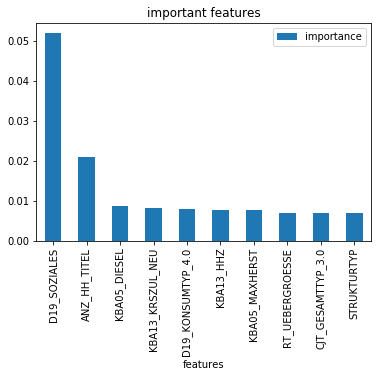

In [132]:
feature_importance.sort_values('importance', ascending=False).head(10).set_index('features').plot.bar()
plt.title("important features")

In [76]:
att = pd.read_csv("../input/attributes/attribute_values_cleaned_checkpoint.csv")

### The most important attributes are the customer's transaction activities in the last 12 months (in the SOZIALES category, in German it means "social"), number of academic title holder in building, share of cars with Diesel-engine in the microcell, share of newbuilt cars (referred to the county average) - PLZ8 and consumption type.

In [81]:
att[att['Attribute'].str.contains('D19_S')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
446,NaN,D19_SAMMELARTIKEL_RZ,transactional activity based on the product group COLLECTABLE ITEMS,0,no transaction known,0__no transaction known
447,NaN,D19_SAMMELARTIKEL_RZ,- on grid level -,1,Multibuyer 0-12 months,1__Multibuyer 0-12 months
448,NaN,D19_SAMMELARTIKEL_RZ,NaN,2,Doublebuyer 0-12 months,2__Doublebuyer 0-12 months
449,NaN,D19_SAMMELARTIKEL_RZ,NaN,3,Singlebuyer 0-12 months,3__Singlebuyer 0-12 months
450,NaN,D19_SAMMELARTIKEL_RZ,NaN,4,Multi-/Doublebuyer 13-24 months,4__Multi-/Doublebuyer 13-24 months
451,NaN,D19_SAMMELARTIKEL_RZ,NaN,5,Singlebuyer 13-24 months,5__Singlebuyer 13-24 months
452,NaN,D19_SAMMELARTIKEL_RZ,NaN,6,Buyer > 24 months,6__Buyer > 24 months
453,NaN,D19_SAMMELARTIKEL_RZ,NaN,7,Prospects > 24 months,7__Prospects > 24 months
454,NaN,D19_SCHUHE_RZ,transactional activity based on the product group SHOES,0,no transaction known,0__no transaction known
455,NaN,D19_SCHUHE_RZ,- on grid level -,1,Multibuyer 0-12 months,1__Multibuyer 0-12 months


In [134]:
att[att['Attribute'].str.contains('KBA05_D')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
852,NaN,KBA05_DIESEL,share of cars with Diesel-engine in the microcell,"-1, 9",unknown,"-1, 9__unknown"
853,NaN,KBA05_DIESEL,NaN,0,none,0__none
854,NaN,KBA05_DIESEL,NaN,1,very low,1__very low
855,NaN,KBA05_DIESEL,NaN,2,low,2__low
856,NaN,KBA05_DIESEL,NaN,3,average,3__average
857,NaN,KBA05_DIESEL,NaN,4,high,4__high


In [136]:
att[att['Attribute'].str.contains('KBA13_KRSZUL')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
1568,NaN,KBA13_KRSZUL_NEU,share of newbuilt cars (referred to the county average) - PLZ8,-1,unknown,-1__unknown
1569,NaN,KBA13_KRSZUL_NEU,NaN,0,none,0__none
1570,NaN,KBA13_KRSZUL_NEU,NaN,1,low,1__low
1571,NaN,KBA13_KRSZUL_NEU,NaN,2,average,2__average
1572,NaN,KBA13_KRSZUL_NEU,NaN,3,high,3__high


In [87]:
att[att['Attribute'].str.contains('KBA13_HALTER_40')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
1378,NaN,KBA13_HALTER_40,share of car owners between 36 and 40 within the PLZ8,-1,unknown,-1__unknown
1379,NaN,KBA13_HALTER_40,NaN,0,none,0__none
1380,NaN,KBA13_HALTER_40,NaN,1,very low,1__very low
1381,NaN,KBA13_HALTER_40,NaN,2,low,2__low
1382,NaN,KBA13_HALTER_40,NaN,3,average,3__average
1383,NaN,KBA13_HALTER_40,NaN,4,high,4__high
1384,NaN,KBA13_HALTER_40,NaN,5,very high,5__very high


In [93]:
att[att['Attribute'].str.startswith('ANZ_')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
36,NaN,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),…__numeric value (typically coded from 1-10)
37,NaN,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10),…__numeric value (typically coded from 1-10)
38,NaN,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3),…__numeric value (typically coded from 1-3)
39,NaN,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10),…__numeric value (typically coded from 1-10)


In [138]:
att[att['Attribute'].str.startswith('D19_KONSUM')]

,Unnamed: 0,Attribute,Description,Value,Meaning,value__meaning
384,NaN,D19_KONSUMTYP,consumption type,1,Universal,1__Universal
385,NaN,D19_KONSUMTYP,NaN,2,Versatile,2__Versatile
386,NaN,D19_KONSUMTYP,NaN,3,Gourmet,3__Gourmet
387,NaN,D19_KONSUMTYP,NaN,4,Family,4__Family
388,NaN,D19_KONSUMTYP,NaN,5,Informed,5__Informed
389,NaN,D19_KONSUMTYP,NaN,6,Modern,6__Modern
390,NaN,D19_KONSUMTYP,NaN,9,Inactive,9__Inactive
